<a href="https://colab.research.google.com/github/Dragon116rus/Adversarial_black_box_attack/blob/master/cifar10_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import gc

In [0]:
tqdm = lambda x:  x

In [0]:
noise_scale = 0.4

In [6]:


transform_train = transforms.Compose(
    [
    #  transforms.RandomHorizontalFlip(p=0.5),
    #  transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

transform_test = transforms.Compose(
    [
     transforms.ToTensor(),
     
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

transform_train_noise = transforms.Compose(
    [
    #  transforms.RandomHorizontalFlip(p=0.5),
    #  transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Lambda(lambda x : x + noise_scale*torch.randn_like(x)),
     ])

transform_test_noise = transforms.Compose(
    [
    #  transforms.RandomHorizontalFlip(p=0.5),
    #  transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Lambda(lambda x : x + noise_scale*torch.randn_like(x)),
     ])

batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


trainset_noise = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train_noise)
trainloader_noise = torch.utils.data.DataLoader(trainset_noise, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_noise = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test_noise)
testloader_noise = torch.utils.data.DataLoader(testset_noise, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

 98%|█████████▊| 167501824/170498071 [00:11<00:00, 17376037.73it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


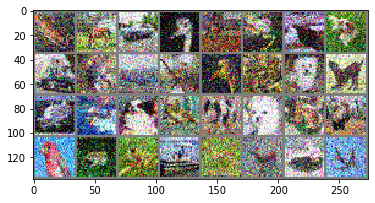

 ship horse   car  bird


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_noise)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)

        x = self.pool(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        x = self.pool(x)

        # x = self.conv5(x)
        # x = self.batchnorm5(x)
        # x = F.relu(x)
        # x = self.conv6(x)
        # x = self.batchnorm6(x)
        # x = F.relu(x)
        # x = self.pool(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        # x = torch.softmax(x, 1)
        
        return x

    def soft_forward(self, x, temperature):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)

        x = self.pool(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = x/temperature
        x = torch.softmax(x, 1)
        return x



net = Net()
net.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

In [0]:
# class ResNetBottom(nn.Module):
#     def __init__(self, original_model):
#         super(ResNetBottom, self).__init__()
#         self.features = nn.Sequential(*list(original_model.children())[:-1])
#         self.fc = nn.Linear(512, 10)
        
#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x, 1)
#         return self.fc(x)

# res18_model = torchvision.models.resnet18(pretrained=True)
# net = ResNetBottom(res18_model)

In [0]:
# net = torchvision.models.resnet18(pretrained=False, )

In [0]:
def validate(net, add_noise=False):
  net.eval()
  predict_all = []
  true_labels_all = []
  add_noise_f = lambda x : x + noise_scale*torch.randn_like(x)
  for i, data in tqdm(enumerate(testloader, 0)):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    if add_noise:
      inputs = add_noise_f(inputs)
    outputs = net(inputs).cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    predict_all += list(np.argmax(outputs, axis=1))
    true_labels_all += list(labels)
  print("accuracy:", (np.array(true_labels_all)==np.array(predict_all)).mean())
  net.train()

In [0]:
net.cuda()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000 * 40, gamma=0.33)

In [0]:
net.train()
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader_noise, 1)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch, i, running_loss / 1000))
            running_loss = 0.0
    

    gc.collect()
    torch.cuda.empty_cache()  
    torch.save(net.state_dict(), "model_epoch%s.dms"%epoch)
    validate(net, True)
print('Finished Training')

[0,  1000] loss: 1.642
accuracy: 0.4845
[1,  1000] loss: 1.368
accuracy: 0.535
[2,  1000] loss: 1.278
accuracy: 0.5587
[3,  1000] loss: 1.213
accuracy: 0.5509
[4,  1000] loss: 1.176
accuracy: 0.5748
[5,  1000] loss: 1.138
accuracy: 0.5985
[6,  1000] loss: 1.110
accuracy: 0.605
[7,  1000] loss: 1.079
accuracy: 0.6192
[8,  1000] loss: 1.057
accuracy: 0.6134
[9,  1000] loss: 1.049
accuracy: 0.6208
[10,  1000] loss: 1.027
accuracy: 0.6244
[11,  1000] loss: 1.011
accuracy: 0.6377
[12,  1000] loss: 0.991
accuracy: 0.6278
[13,  1000] loss: 0.990
accuracy: 0.6372
[14,  1000] loss: 0.974
accuracy: 0.634
[15,  1000] loss: 0.957
accuracy: 0.6522
[16,  1000] loss: 0.951
accuracy: 0.6572
[17,  1000] loss: 0.938
accuracy: 0.637
[18,  1000] loss: 0.938
accuracy: 0.6454
[19,  1000] loss: 0.924
accuracy: 0.6511
[20,  1000] loss: 0.914
accuracy: 0.6543
[21,  1000] loss: 0.911
accuracy: 0.6609
[22,  1000] loss: 0.902
accuracy: 0.6716
[23,  1000] loss: 0.896
accuracy: 0.6642
[24,  1000] loss: 0.894
accura

KeyboardInterrupt: ignored

In [0]:
!cp  model_epoch75.dms "gdrive/My Drive/Colab Notebooks/Study/theasis/model1_cifar_noise.dms"

In [0]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
!cp  "gdrive/My Drive/Colab Notebooks/Study/theasis/model1.dms" model1.dms

In [0]:
!cp  "gdrive/My Drive/Colab Notebooks/Study/theasis/model1_cifar_noise.dms" model1_noise.dms

In [0]:
!cp  "gdrive/My Drive/Colab Notebooks/Study/theasis/model3.dms" model3.dms 

In [0]:
net.load_state_dict(torch.load('model1.dms'))

<All keys matched successfully>

In [0]:
net2 = Net().cuda()

In [0]:
net2.load_state_dict(torch.load('model1_noise.dms'))

<All keys matched successfully>

In [0]:

validate(net, add_noise=False), validate(net, add_noise=True);

accuracy: 0.8402
accuracy: 0.1469


(None, None)

In [0]:
validate(net2, add_noise=False), validate(net2, add_noise=True);

accuracy: 0.6051
accuracy: 0.7071


(None, None)

In [10]:
net3 = Net()
net3.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

In [0]:
net3.load_state_dict(torch.load('model3.dms'))
validate(net3)

accuracy: 0.687


In [0]:
criterion3_1 = nn.CrossEntropyLoss()
criterion3_2 = nn.BCEWithLogitsLoss()
optimizer3 = optim.Adam(net3.parameters(), lr=1e-3)
scheduler3 = optim.lr_scheduler.StepLR(optimizer3, step_size=1000 * 20, gamma=0.33)

In [0]:
add_noise = lambda x : x + noise_scale*torch.randn_like(x)

In [0]:
net3.train()
temperature = 1
for epoch in range(240):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 1)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        inputs_noise = add_noise(inputs).detach()
        # zero the parameter gradients
        optimizer3.zero_grad()

        # forward + backward + optimize
        out_s = net3(inputs_noise)
        out_t = net(inputs)
        soft_log_probs = F.log_softmax(out_s / temperature, dim=1)
        soft_targets = F.softmax(out_t / temperature, dim=1)
        
        # loss1 = criterion3_1(out_s, (labels))
        # loss2 = criterion3_2(out_s, torch.from_numpy(soft_labels))
        # loss = 0.10*loss1 + 0.90*loss2
        distillation_loss = F.kl_div(soft_log_probs, soft_targets.detach(), reduction='mean') 
        loss = distillation_loss  #+  0.50*loss1 
        loss.backward()
        optimizer3.step()
        scheduler3.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i, running_loss / 500))
            running_loss = 0.0
            print("lr:", scheduler3.get_lr())
    

    gc.collect()  
    torch.cuda.empty_cache()  
    torch.save(net3.state_dict(), "model3_epoch%s.dms"%epoch)
    validate(net3, add_noise=True)
print('Finished Training')

In [0]:
!cp  model3_epoch96.dms "gdrive/My Drive/Colab Notebooks/Study/theasis/model3_cifar_noise.dms"

In [0]:
!cp "gdrive/My Drive/Colab Notebooks/Study/theasis/model3_cifar_noise.dms" model3_cifar_noise.dms

In [13]:
net3.load_state_dict(torch.load('model3_cifar_noise.dms'))
validate(net3)

accuracy: 0.6293


In [14]:
validate(net3, add_noise=True)

accuracy: 0.7262
